# **Classification de ressentis avec CamemBERT**

L'objectif est de créer un modèle qui prend en entrée des commentaires (en Français) et attribue à chacun un ressenti positif ou négatif.  
Le modèle global est composé de deux parties :  
* [CamemBERT](https://camembert-model.fr/) va encoder le commentaire et en extraire des informations qui seront passées ensuite au réseau de neurones.  
* Le modèle suivant est un réseau de neurones qui sera créé avec l'API [Keras](https://www.tensorflow.org/guide/keras?hl=fr) de [Tensorflow](https://www.tensorflow.org/?hl=fr).  

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/StructureBERT.png" />  
  
  Les données qui s'échangent entre les deux modèles sont des vecteurs de dimension 768. On peut voir ces vecteurs comme l'équivalent de l'application d'un algorithme de prolongation lexicale sur les mots qui composent le commentaire.

In [1]:
!pip install transformers --quiet

     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 890kB 12.8MB/s 
     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 3.0MB 23.5MB/s 


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import CamembertConfig
from transformers import TFCamembertModel
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

# Importation des données

Téléchargement des ressentis Allociné

In [3]:
# Téléchargement des données depuis le repot github "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"

!wget -q "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"
!tar -xjvf data.tar.bz2

data/
data/allocine_dataset.pickle
data/test.jsonl
data/train.jsonl
data/val.jsonl


In [4]:
df = pd.read_json("/content/data/test.jsonl", lines=True)
df.head(5)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/cr...,"Magnifique épopée, une belle histoire, touchan...",1
1,http://www.allocine.fr/film/fichefilm-1954/cri...,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,http://www.allocine.fr/film/fichefilm-135523/c...,Un dessin animé qui brille par sa féerie et se...,1
3,http://www.allocine.fr/film/fichefilm-61514/cr...,"Si c'est là le renouveau du cinéma français, c...",0
4,http://www.allocine.fr/film/fichefilm-260395/c...,Et pourtant on s’en Doutait !Second volet très...,0


Affiche quelques informations :

In [5]:
def LongueurMax(df):
  Lmax = 0
  for com in df['review']:
    Longueur = len(com)
    if Lmax < Longueur:
      Lmax = Longueur
  return Lmax

In [6]:
print(df[0:10])
print("Total des données : ", str(len(df)))
print("Nombre d'avis positifs et négatifs : ",df['polarity'].value_counts())
print("Longueur maximale d'un commentaire : ",LongueurMax(df))

                                            film-url  ... polarity
0  http://www.allocine.fr/film/fichefilm-25385/cr...  ...        1
1  http://www.allocine.fr/film/fichefilm-1954/cri...  ...        0
2  http://www.allocine.fr/film/fichefilm-135523/c...  ...        1
3  http://www.allocine.fr/film/fichefilm-61514/cr...  ...        0
4  http://www.allocine.fr/film/fichefilm-260395/c...  ...        0
5  http://www.allocine.fr/film/fichefilm-220641/c...  ...        1
6  http://www.allocine.fr/film/fichefilm-120103/c...  ...        1
7  http://www.allocine.fr/film/fichefilm-190956/c...  ...        1
8  http://www.allocine.fr/film/fichefilm-186185/c...  ...        1
9  http://www.allocine.fr/film/fichefilm-17327/cr...  ...        0

[10 rows x 3 columns]
Total des données :  20000
Nombre d'avis positifs et négatifs :  0    10408
1     9592
Name: polarity, dtype: int64
Longueur maximale d'un commentaire :  2000


# **Préparation des données**


In [32]:
def LongueurMax2(df):
  Lmax = 0
  for com in df:
    Longueur = len(com)
    if Lmax < Longueur:
      Lmax = Longueur
  return Lmax

In [35]:
# Chargement des commentaires et des ressentis
commentaires = df['review'].astype(str).tolist()    # Récupère tous les commentaires dans une liste python
ressentis = df['polarity'].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)               # Créé un tableau de type numpy avec les ressentis

x_entrainement, x_test, y_entrainement, y_test = train_test_split(commentaires[0:MAX], labels[0:MAX], test_size=0.25)

In [36]:
Longueur_max_entrainement = LongueurMax2(x_entrainement)
Longueur_max_tests = LongueurMax2(x_test)
print("Longueur maximale des commentaires : ", max([Longueur_max_entrainement, Longueur_max_tests]))

Longueur maximale des commentaires :  2000


In [29]:
print ("Nombre de commentaires pour l'entrainement : ", len(x_entrainement))
print ("Nombre de commentaires pour les tests : ", len(x_test))

Nombre de commentaires pour l'entrainement :  2250
Nombre de commentaires pour les tests :  750


# **Tokénisation**


In [38]:
LONGUEUR_MAX_COMMENTAIRE = max([Longueur_max_entrainement, Longueur_max_tests]) + 2

# Instanciation du tokeniseur
tokenizer = AutoTokenizer.from_pretrained('jplu/tf-camembert-base')

# Préparation des données d'entrainement
output_tokenizer_entrainement = tokenizer(x_entrainement,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

# Préparation des données de tests
output_tokenizer_tests = tokenizer(x_test,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

Regardons un peu comment sont formatées les données en sortie du tokéniseur :

In [16]:
output_tokenizer_entrainement

{'input_ids': <tf.Tensor: shape=(2250, 2002), dtype=int32, numpy=
array([[   5,  799,  248, ...,    1,    1,    1],
       [   5,   87, 1003, ...,    1,    1,    1],
       [   5,  153, 2560, ...,    1,    1,    1],
       ...,
       [   5,  153,  918, ...,    1,    1,    1],
       [   5,   54,  565, ...,    1,    1,    1],
       [   5,  100,  676, ...,    1,    1,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2250, 2002), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

Regardons comment le premier commentaire a été encodé :

In [15]:
print("Commentaire original :", x_entrainement[0])
print("input_ids: ", output_tokenizer_entrainement['input_ids'][0])
print("attention_mask: ", output_tokenizer_entrainement['attention_mask'][0])

Commentaire original : Que dire de ce film... l'Apprenti est utra-soporifique, les dialogues sont creux: "J'crois que j'taime encore.Ca m'fé plaiz". Certaines scènes sont très incohérentes, comme celle du bar où les jeunes chantent "c'est un ivrogne, il est des nôtres..." bouteilles de bière à la main, buvant du sirop de menthe(?).Ce film incarne un certaine "beaufitude", de par ses personnages, les situations et l'environnement. Enfin l'Apprenti du film n'est pas du tout un personnage attachant, au contraire.
input_ids:  tf.Tensor([  5 799 248 ...   1   1   1], shape=(2002,), dtype=int32)
attention_mask:  tf.Tensor([1 1 1 ... 0 0 0], shape=(2002,), dtype=int32)


# **Définition et utilisation du modèle camemBERT avec Keras**

In [39]:
# Instanciation du modèle camemBERT
transformer_model = TFCamembertModel.from_pretrained('jplu/tf-camembert-base')

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_camemBERT = transformer_model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_camemBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_camemBERT,trainable=False)
model_camemBERT.summary()

Some weights of the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 2002)]       0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 2002)]       0                                            
__________________________________________________________________________________________________
tf_camembert_model_2 (TFCamembe ((None, 2002, 768),  110621952   input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 110,621,952
Trainable params: 0
Non-trainable params: 110,621,952
__________________________________________________________________________________________________


Si on regarde le format de la sortie du modèle camemBERT, on voit qu'elle est composée de deux sorties :
* Une sortie avec un format (None,MAX_SEQUENCE_LENGTH,768)
* Une sortie avec un format (None,768)  
  
On trouve la signification de ces sorties [sur le site de hugginface](https://huggingface.co/transformers/main_classes/output.html#tfbasemodeloutput). Ainsi, la première sortie est de type `last_hidden_state` et la deuxième de type `pooler_output`.

In [11]:
sortie_camemBERT

(<tf.Tensor 'tf_camembert_model/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 2002, 768) dtype=float32>,
 <tf.Tensor 'tf_camembert_model/roberta/pooler/dense/Tanh:0' shape=(None, 768) dtype=float32>)

 Celle qui nous interesse ici est la sortie `last_hidden_state` : C'est elle qui contient le résultat de l'encodage des mots des commentaires

In [12]:
sortie_camemBERT[0]

<tf.Tensor 'tf_camembert_model/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 2002, 768) dtype=float32>

La fonction `predict()` permet d'exécuter le modèle sur les séquences d'entrées

In [13]:
sortie_vecteurs_camemBERT = model_camemBERT.predict(
    [output_tokenizer_entrainement['input_ids'][0:2],
     output_tokenizer_entrainement['attention_mask'][0:2]]
     ,verbose=1)

1/1 [==============================] - 0s 11ms/step


Regardons à quoi ressemble la sortie de distilBERT :

In [ ]:
sortie_vecteurs_camemBERT

# **Ajout du réseau de neurones simple en sortie du modèle distilBERT**

**Extraction des vecteurs [CLS]**

Parmi les MAX_SEQUENCE_LENGTH vecteurs en sortie, il ne nous faut que le premier (celui qui correspond au mot clé [CLS]). On doit donc récupérer, pour chaque commentaire, le premier vecteur de dimension 768 parmi les MAX_SEQUENCE_LENGTH en sortie :  

In [ ]:
sortie_camemBERT[0]

<tf.Tensor 'tf_camembert_model/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 2002, 768) dtype=float32>

**Construction du modèle global**

Les vecteurs de dimension 768 correspondants aux sorties [CLS] de chaque commentaire sont envoyés dans un réseau de neurones à 2 neurones avec une fonction d'activation Softmax :
<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/ReseauDistilBERT1.png"/>

In [40]:
# Instanciation du modèle camemBERT
transformer_model = TFCamembertModel.from_pretrained('jplu/tf-camembert-base')

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_camemBERT = transformer_model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_camemBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_camemBERT,trainable=False)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_camemBERT = transformer_model([entrees_ids,entrees_masks])[0]


l1 = Lambda(lambda seq: seq[:, 0, :])(sortie_camemBERT)        # On ne récupère que les vecteurs [CLS]
output = Dense(2, activation='softmax')(l1)

model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.layers[2].trainable = False         # Désactive d'entrainement de camemBERT

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Some weights of the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 2002)]       0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 2002)]       0                                            
__________________________________________________________________________________________________
tf_camembert_model_3 (TFCamembe ((None, 2002, 768),  110621952   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768)          0           tf_camembert_model_3[

On lance maintenant l'entrainement du modèle :

In [ ]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

Epoch 1/5
111/750 [===>..........................] - ETA: 6:02 - loss: 0.6741 - accuracy: 0.5736

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

# **Fine Tuning**

Afin d'obtenir une meilleur précision, on va également entrainer camemBERT : 

In [ ]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti ((None, 273, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768)          0           tf_distil_bert_model_2

In [ ]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

Epoch 1/5
750/750 [==============================] - 85s 114ms/step - loss: 0.3706 - accuracy: 0.8356 - val_loss: 0.3417 - val_accuracy: 0.8667
Epoch 2/5
750/750 [==============================] - 87s 116ms/step - loss: 0.1593 - accuracy: 0.9329 - val_loss: 0.3125 - val_accuracy: 0.8880
Epoch 3/5
750/750 [==============================] - 88s 117ms/step - loss: 0.0635 - accuracy: 0.9769 - val_loss: 0.4711 - val_accuracy: 0.8653
Epoch 4/5
750/750 [==============================] - 89s 118ms/step - loss: 0.0241 - accuracy: 0.9907 - val_loss: 0.4908 - val_accuracy: 0.8773
Epoch 5/5
750/750 [==============================] - 89s 118ms/step - loss: 0.0358 - accuracy: 0.9898 - val_loss: 0.4185 - val_accuracy: 0.8920


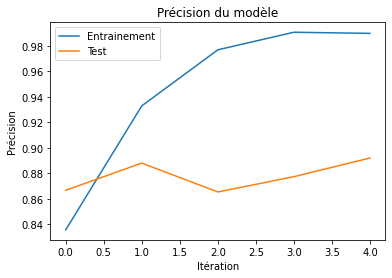

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()